<a href="https://colab.research.google.com/github/abrarum/bezierobjdet/blob/main/TESTS/workspace/mobile/index2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
#%reset -f

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#!pip install bezier
import bezier
#!pip uninstall matplotlib
#!pip install matplotlib
import tensorflow as tf
from tensorflow import keras

import math

import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
#import matplotlib
#print('matplotlib: {}'.format(matplotlib.__version__))

from PIL import Image, ImageDraw
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, UpSampling2D, ZeroPadding2D, Flatten, Conv1D, Conv2D, Conv3D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from keras.layers.merge import add, concatenate

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [3]:
image_width = image_height = 600
gridcell = 18
li_output_size = 4

# Make it False for non-COLAB env
COLAB = False

colab_base_url = '/content/drive/MyDrive/bezierobj/bezierobjdet/TESTS/workspace/mobile/'

image_root = './images/multi_lines/train/' if COLAB == False else colab_base_url+'images/multi_lines/train'
image_labels = ['line']

total_files = fnmatch.filter(os.listdir(image_root), '*.png')
#print(len(total_files))

csv_path =  './images/multi_lines/train.csv' if COLAB == False else colab_base_url+'images/multi_lines/train.csv'
df=pd.read_csv(csv_path, sep=',',header=0)

def image_read(fn):
    ''' read file_name, converts it in to RGB and return an image array '''
    link = os.path.join(image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    return im

def getInfo(fn):
    ''' returns image, gtruth pixels (gridcell x gridcell x 1) and coordinates (gridcell x gricell x 4) '''
    image = image_read(fn+".png")
    
    rows = np.where(df.filename==fn)
    
    class_id = df["class"][rows[0][0]]
    coords = []
    
    for i in rows[0]:
        c_id = []
        c_coord = []
        
        c_coord.append(df.x_0[i])
        c_coord.append(df.x_1[i])
        #c_coord.append(df.x_2[i])
        
        #the Y coordinate axis in the annotations starts at bottom
        #inverting
        c_coord.append(image_height - df.y_0[i])
        c_coord.append(image_height - df.y_1[i])
        #c_coord.append(image_height - df.y_2[i])
        
        coords.append(c_coord)
        c_id = []
        
    return image, class_id, coords

#getInfo("li_1658")

# PLOT LINE

In [4]:
def degree_calc(coord):
    ''' calculates degree used by curve.plot --- should be 1 less than the no. of nodes in the coord '''
    nonzero_count = np.count_nonzero(coord)
    degree = nonzero_count-1
    return degree

def plot_line(image, pred_coords, norm=False):
    ''' create a canvas image on an axis incorp. image and coordinates into 1. '''
    
    figo = Figure(figsize=(8.334, 8.334))

    canvas = FigureCanvasAgg(figo)

    # plot
    #ax_r = figo.add_subplot()
    _, ax = plt.subplots()
    
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    ax.imshow(image)
    
    # creates each line over image
    for i in pred_coords:
        #x_0, x_1, x_2, y_0, y_1, y_2 = i
        x_0, x_1, y_0, y_1 = i
        #curve1 = bezier.Curve([[x_0, x_1, x_2], [y_0, y_1, y_2]], degree=2)
        curve1 = bezier.Curve([[x_0, x_1], [y_0, y_1]], degree=1)
        curve1.plot(num_pts=256, ax=ax, color="black", alpha=2)
            
    #plt.axis('off')
    
    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

def randlGen():
    ''' random image generator from data file_name '''
    rElem = np.random.choice(total_files)
    rElem = rElem[0:-4]
    #print(rElem)
    return rElem

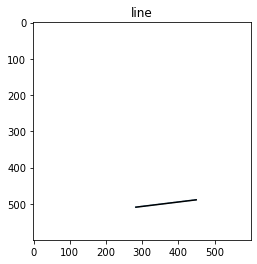

In [5]:
# testing getInfo and plot_line
image, class_id, pred_coords = getInfo(randlGen())

image = plot_line(image, pred_coords, norm=False)
plt.imshow(image)
plt.title("line")
#plt.tight_layout(pad=0)
plt.show()

***

# Pixel gTruth and Line gTruth

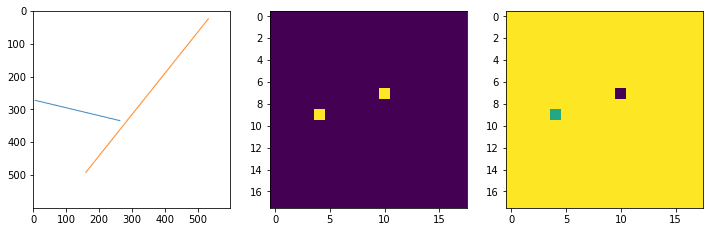

In [6]:
def target_calc(coord):
    ''' how far from the mp of line in the gridcell and the other 
        2 coordinates relative to the whole image and line center
        '''
    
    targets = []
    
    # ------------- COORD Mapping --------------
    
    # coord - image_width (used as a base to calculate coord_grid and coord_one)
    original_coord = coord
    
    # coord - gridcell (used to calcute mp_grid)
    coord_grid = linear(original_coord, image_width, gridcell)
    
    # coord - 1x1 (used to calculate relative coords)
    coord_one = linear(coord_grid, image_width, 1)
    
    # ------------ COORD Splitting ----------------
    
    split_coord_grid  = np.split(coord_grid, len(coord_grid)/2)
    
    split_coord_one = np.split(coord_one, len(coord_one)/2)
    
    # ------------- MIDPOINT Mapping --------------
    
    mp_grid = np.floor(midPoint(split_coord_grid))
    
    mp_grid_one = linear(mp_grid, gridcell, 1)
    
    # ------------- relative pts calculation ------
    
    # calculate targets by subtracting mp values from pairs [[x,x],[y,y]]
    for i,k in enumerate(split_coord_one):
        temp_t = []
        
        for j in k:
            j = j.item()
            temp_t.append(j-mp_grid_one[i][0])
        targets.append(temp_t)
        
    targets = np.concatenate(targets)
    
    return targets, mp_grid


def linear(coord, oldmax, newmax):
    '''Converts coordinates from scale `image_height`x`image_width`
       to scale `gridcell`x`gridcell` '''
    
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = oldmax
        OldMin = 0
        NewMax = newmax
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)

def midPoint(p12):
    ''' generates mid-points coords of the mapped line/curve '''

    # finds the halfway (0.50 - midpoint controlpoint coord) of the curve
    curve1 = bezier.Curve(p12, degree=len(p12)-1)
    mp = curve1.evaluate(0.50)
    
    return mp

def gtruther(index):
    ''' generates truth pixels (Shape = gricell x gricell x 1) and line coordinate truth (gricell x gridcell x 4) '''
    image, class_id, coords = getInfo(index)
    
    # truther shapes
    pxTruth = np.zeros((gridcell,gridcell,1))
    liTruth = np.zeros((gridcell,gridcell,li_output_size))
    
    if (class_id == 1):
        for i in coords:
            
            # for each coord in the array, calculate targets
            re_targ, mp = target_calc(i)
            
            # convert to ints
            mp = mp.reshape(-1)
            x, y = mp.astype(int)
            
            # allot line gt coords of mp coords to liTruth shape
            liTruth[y][x] = re_targ
            pxTruth[y][x] = [class_id]

    return image, liTruth, pxTruth, class_id
    

def test_sbs(index):
    ''' tests the truth values '''
    image, class_id, coords = getInfo(index)
    pimg, liTruth, pxTruth, class_id = gtruther(index)
    
    plt.figure(0, (12,8))
    plt.subplot(1, 3, 1)
    #plt.tight_layout(pad=0)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(pxTruth)
    plt.subplot(1, 3, 3)
    plt.imshow(liTruth[...,1])
    
test_sbs("li_3406")

***
# DATA GEN

In [7]:
batch_size = 32

def regression_weight_map(cls_target):
    '''Creates a weight map for the regression target.
       The weight map is 1.0 where the classification target is not zero.
       Shape=(B,H,W)  (no channel dimension as required by the loss functions)'''
    return (cls_target[...,0] > 0).astype('float32')

def data_generator(batch_size=batch_size):
    ''' generates data for the model '''
    while True:
        x_batch = np.zeros((batch_size, image_height, image_width, 3))
        y_batch = np.zeros((batch_size, gridcell, gridcell, 1))
        bline_batch   = np.zeros((batch_size, gridcell, gridcell, li_output_size))

        for i,j in enumerate(total_files[0:batch_size]):
            # random index image and truth values
            image, liTruth, pxTruth, class_id = gtruther(randlGen())
            
            x_batch[i] = image / 255.
            y_batch[i] = pxTruth
            bline_batch[i] = liTruth
            
        sample_weight = regression_weight_map(y_batch)
        #, {'class_out': sample_weight, 'line_out': sample_weight}
        yield ({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch}, {'class_out': sample_weight, 'line_out': sample_weight})

***
# MODEL

In [8]:
def modelTester():
    '''' model '''
    input_ = Input(shape=(image_height, image_width, 3), name='image')

    x = input_

    for i in range(0, 5):
      n_filters = 2**(4 + i)
      x = Conv2D(n_filters, 1, activation='relu')(x)
      x = BatchNormalization()(x)
      x = MaxPool2D(2)(x)
    
    x = Dropout(0.50)(x)
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(li_output_size, (1,1), name="line_out")(x)
    
    model = tf.keras.models.Model(input_, [x1,x2])
    model.summary()
    return model
    
model = modelTester()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 600, 600, 16) 64          image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 600, 600, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 300, 300, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(
    loss={
        #from_logits=True if class_out has no activation function
        #from_logits=False if class_out has sigmoid activation
        'class_out': keras.losses.BinaryCrossentropy(from_logits=True),
        'line_out': 'mse'
    },
    loss_weights={ 'class_out':1.0, 'line_out':1e-5 },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics={
        'class_out': 'accuracy',
        'line_out': [tf.keras.metrics.MeanAbsoluteError()]
    },
)

In [10]:
def relative_to_lines(pred_coord, mp):
    '''
        Strategy:
        
        (X) Pixel range -- pred_coord => (1 x 1)
                        --         mp => (gridcell x gridcell)
        (X) Execution:
                        1. For each mp (filtered class truth), calculate mp's new pixel range (1 x 1)
                        2. Add each individual mp and coordinates value with corresponding axes
                        3. convert the resulting coordinates to 'gridcell x gridcell'
    '''
    #print(mp)
    
    new_coord = []
    
    for i in mp:
        # switch mp position - [y,x] to [x,y]
        y, x = i
        
        #print("mp", mp)
        
        rel_coords = pred_coord[y][x]
        
        #mp = [p/gridcell for p in i]
        mp = linear(i, gridcell, 1)
        
        #print("mp", mp)
        #print("rel_coords", rel_coords)
        
        temp = []
        
        for i,l in enumerate(rel_coords):
            
            if(i < len(rel_coords)/2):
                temp.append(l+mp[0])
            else:
                temp.append(l+mp[1])
        
        #print("temp_old", temp)
        
        temp = [i*image_width for i in temp]
        
        #print("temp_new", temp)
        
        new_coord.append(temp)        
    
    #print(new_coord)
    return new_coord
    
def non_maximum_suppression(class_id):
    ap = tf.nn.max_pool2d(class_id, 3, strides=3, padding="SAME")
    #print("ap", ap[0])
    #mask = (class_id == ap).float().clamp(min=0.0)
    #return class_id * mask
    
    return ap

#test(model)

In [22]:
def test_model(model, test_datagen):
    ''' tests model by taking a value from the generator, predicts the value and plot the lines '''
    
    # data gen
    example, label, _ = next(test_datagen)

    # extracting image and class_id from data gen
    image = example['image']
    class_id = label['class_out']

    # truthy 'ground' pixel count (1s) / line count in the image
    gtcount = np.count_nonzero(class_id[0])
    
    # predicted classes and lines
    pred_class, pred_line = model.predict(image)
    
    #print("pred_class", pred_class)
    
    # sigmoid (to remove -ve values and align them b.w 0 and 1)
    sigmoided_clas = tf.keras.activations.sigmoid(pred_class)
    sigmoided_line = tf.keras.activations.sigmoid(pred_line)
    
    #print("sigmoided", sigmoided)

    # filter out by initial threshold
    filtered_indices = [(i[0],i[1]) for i in np.argwhere(sigmoided_clas[0] > 0.99)]
    
    # truthy 'predicted' line count (1s) / line count in the image
    pred_count = len(filtered_indices)
    
    # relative coordinates to actual line formation
    pred_coords = relative_to_lines(sigmoided_line[0], filtered_indices)
    
    # axes assignment
    gt = 0 if gtcount < 1 else 1
    pred_class_name = 0 if pred_count < 1 else 1
    
    # plot line
    image = plot_line(image[0], pred_coords)

    plt.imshow(image)
    # plot config
    
    color = 'green' if gt == pred_class_name else 'red'
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [12]:
def test(model):
    ''' conducting test '''
    test_datagen = data_generator(1)

    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        #plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    #plt.show()
  

<Figure size 1152x288 with 0 Axes>

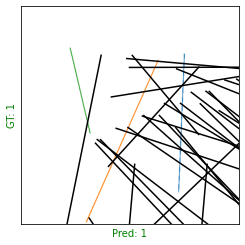

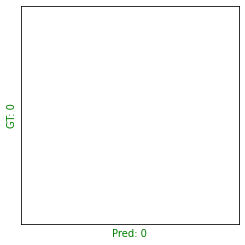

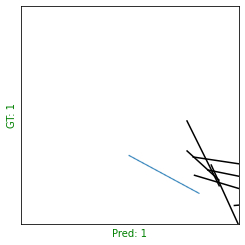

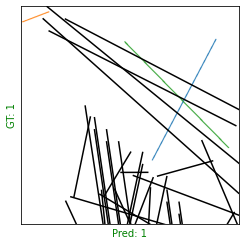

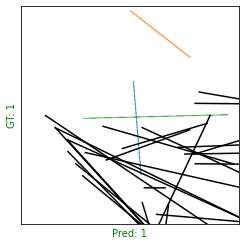

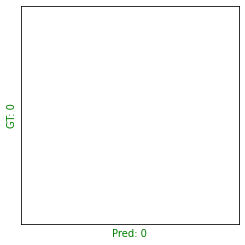

In [23]:
test(model)

In [14]:
class ShowTestImages(tf.keras.callbacks.Callback):
  ''' displays test images after each epoch '''
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

# Model Training

In [15]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(batch_size=32),
    use_multiprocessing=True,
    workers=24,
    epochs=10,
    steps_per_epoch=len(total_files) / batch_size,
    callbacks=[
               #ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='line_out_mean_absolute_error', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)
model_path = './custom_models/mul_singleline_model' if COLAB == False else colab_base_url+'my_model_2'
model.save(model_path)

Epoch 1/10
140/140 [==============================] - 188s 992ms/step - loss: 0.0072 - class_out_loss: 0.0072 - line_out_loss: 0.5629 - class_out_accuracy: 0.9585 - line_out_mean_absolute_error: 0.6135
Epoch 2/10
140/140 [==============================] - 124s 882ms/step - loss: 9.4868e-04 - class_out_loss: 9.4291e-04 - line_out_loss: 0.5768 - class_out_accuracy: 0.9423 - line_out_mean_absolute_error: 0.5925
Epoch 3/10
140/140 [==============================] - 119s 844ms/step - loss: 8.7561e-04 - class_out_loss: 8.7139e-04 - line_out_loss: 0.4212 - class_out_accuracy: 0.9402 - line_out_mean_absolute_error: 0.5717
Epoch 4/10
140/140 [==============================] - 124s 883ms/step - loss: 7.1687e-04 - class_out_loss: 7.1275e-04 - line_out_loss: 0.4117 - class_out_accuracy: 0.9412 - line_out_mean_absolute_error: 0.5402
INFO:tensorflow:Assets written to: ./custom_models/mul_singleline_model/assets


***
**Outputs after a few epochs training**

In [27]:
_x,_y,_ = next(iter(data_generator()))
_out_cls, _out_reg = model.predict(_x['image'])

#for i in _out_cls:
#    print(i)

#sigmoided_clas = tf.keras.activations.sigmoid(_out_cls)
#for i in sigmoided_clas:
#    print(i)

#print("original: ", _out_cls)
#sigmoided_clas = tf.keras.activations.sigmoid(_out_cls)
#print("sigmoided", sigmoided_clas)

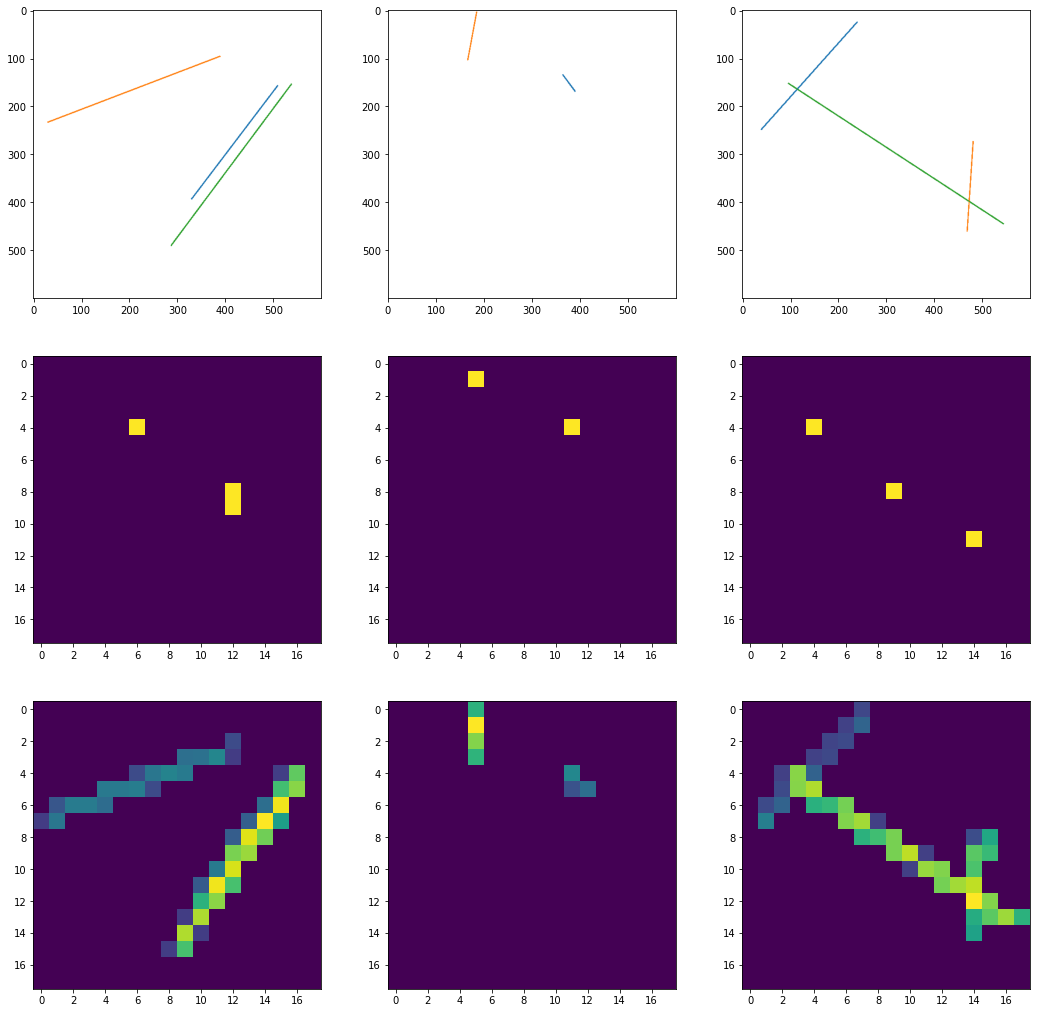

In [28]:
i = 1

plt.figure(0, (18,18))
for i,j in enumerate([3,6,10]):
    plt.subplot(3,3,i+1);   plt.imshow(_x['image'][j])
    plt.subplot(3,3,i+1+3); plt.imshow(_y['class_out'][j])
    plt.subplot(3,3,i+1+6); plt.imshow(_out_cls[j])